**Multiclass Argument Classification with Transformers**

This notebook trains a transformer-based models to perform multiclass classification on a dataset of political statements annotated as: 'claim', 'premise', and, 'non-arg'.

The goal is to automatically classify each sentence into one of these three argumentative categories using a fine-tuned Transformer model.

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 146.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 131.4 MB/s eta 0:00:00
Processing /colabtools/dist/google_colab-1.0.0.tar.gz (from -r requirements.txt (line 170))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google_colab-1.0.0.tar.gz'



In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.3 MB/s eta 0:00:00


In [3]:
# Imports and Setup

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Disable WandB Logging
os.environ["WANDB_DISABLED"] = "true"

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Configuration
# Model and Data Config
MODEL_NAME = "bert-base-german-dbmdz-uncased"
DATA_PATH = "ArgUNSC_en_de.xlsx"
MAX_LEN = 256
LABEL_MAP = {'claim': 0, 'premise': 1, 'non-arg': 2}
NUM_LABELS = len(LABEL_MAP)

In [5]:
# Utility Functions
def map_labels(dataframe):
    dataframe['Task_Label'] = dataframe['Component_Type'].map(LABEL_MAP)
    return dataframe

def split_data(df):
    train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['Task_Label'], random_state=SEED)
    val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['Task_Label'], random_state=SEED)
    return train_df, val_df, test_df

def get_class_weights(labels):
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float)

def save_misclassified(preds, labels, dataframe, tokenizer, path):
    misclassified_mask = preds != labels
    misclassified_df = dataframe[misclassified_mask].copy()
    misclassified_df["Predicted_Label"] = preds[misclassified_mask]
    misclassified_df["True_Label"] = labels[misclassified_mask]
    misclassified_df.to_excel(path, index=False)
    print(f"Misclassified examples saved to: {path}")

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()


In [6]:
# Dataset Class
class ArgumentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence = str(row['Full_Sentence_de']) if pd.notnull(row['Full_Sentence']) else ""
        encoding = self.tokenizer(
            sentence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        label = int(row['Task_Label'])
        return {
            "input_ids": encoding['input_ids'].squeeze(0),
            "attention_mask": encoding['attention_mask'].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [7]:
# Custom Trainer
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device)
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
      labels = inputs.pop("labels")
      outputs = model(**inputs)
      loss = self.loss_fn(outputs.logits, labels)
      return (loss, outputs) if return_outputs else loss


In [8]:
# Load Data
df = pd.read_excel(DATA_PATH)
df = map_labels(df)
print(f"Total dataset size: {len(df)}")

train_df, val_df, test_df = split_data(df)
print(f"Training size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Total dataset size: 5244
Training size: 3670, Validation size: 787, Test size: 787


In [9]:
# Tokenizer, Dataset & Class Weights
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = ArgumentDataset(train_df, tokenizer, MAX_LEN)
val_dataset = ArgumentDataset(val_df, tokenizer, MAX_LEN)
test_dataset = ArgumentDataset(test_df, tokenizer, MAX_LEN)

class_weights = get_class_weights(train_df["Task_Label"].values)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/247k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/487k [00:00<?, ?B/s]

In [10]:
# Initialize Model
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)


In [11]:
# Hyperparameter Search
# Define the search space
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
    }

# TrainingArguments for the search (placeholders)
search_args = TrainingArguments(
    output_dir="./results_search",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    report_to="none",
    seed=42
)

# Trainer setup with model_init
trainer = CustomTrainer(
    class_weights=class_weights,
    model_init=model_init,
    args=search_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Run hyperparameter search
print("Starting hyperparameter search...\n")

best_run = trainer.hyperparameter_search(
    direction="minimize",
    hp_space=hp_space,
    n_trials=10,
    compute_objective=lambda metrics: metrics["eval_loss"]
)

# Log best run only
print("\nBest Hyperparameters Found:")
print(f"  - Learning rate: {best_run.hyperparameters['learning_rate']}")
print(f"  - Epochs: {best_run.hyperparameters['num_train_epochs']}")
print(f"  - Batch size: {best_run.hyperparameters['per_device_train_batch_size']}")
print(f"  - Validation loss: {best_run.objective}")

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
[I 2025-07-15 02:14:03,700] A new study created in memory with name: no-name-12054c88-1950-49e1-9a0a-17cd8080028b


Starting hyperparameter search...



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.780800
1000,0.551000


[I 2025-07-15 02:16:21,408] Trial 0 finished with value: 0.9261139631271362 and parameters: {'learning_rate': 2.3041921827705256e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.9261139631271362.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.684500


[I 2025-07-15 02:19:02,377] Trial 1 finished with value: 0.9319725632667542 and parameters: {'learning_rate': 2.535091782766282e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.9261139631271362.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.680000


[I 2025-07-15 02:21:43,419] Trial 2 finished with value: 0.8626270294189453 and parameters: {'learning_rate': 1.78245301441035e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.8626270294189453.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-15 02:24:11,589] Trial 3 finished with value: 0.7757536768913269 and parameters: {'learning_rate': 1.7277668296093504e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 0.7757536768913269.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.784100
1000,0.564000
1500,0.363100


[I 2025-07-15 02:27:11,949] Trial 4 finished with value: 1.0567368268966675 and parameters: {'learning_rate': 1.9331576819585177e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8}. Best is trial 3 with value: 0.7757536768913269.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.808500
1000,0.598600
1500,0.400000
2000,0.303800


[I 2025-07-15 02:30:56,073] Trial 5 finished with value: 1.143201231956482 and parameters: {'learning_rate': 1.5753176494655567e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8}. Best is trial 3 with value: 0.7757536768913269.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-15 02:33:24,307] Trial 6 finished with value: 0.7301943898200989 and parameters: {'learning_rate': 1.1163511378497348e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 6 with value: 0.7301943898200989.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.662600


[I 2025-07-15 02:35:28,167] Trial 7 finished with value: 0.8477933406829834 and parameters: {'learning_rate': 2.9998430704903237e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 6 with value: 0.7301943898200989.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.781200
1000,0.582200
1500,0.394300
2000,0.298800


[I 2025-07-15 02:39:12,415] Trial 8 finished with value: 1.1412930488586426 and parameters: {'learning_rate': 1.4645561987156131e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8}. Best is trial 6 with value: 0.7301943898200989.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.672500


[I 2025-07-15 02:41:15,071] Trial 9 finished with value: 0.8174673318862915 and parameters: {'learning_rate': 2.3371731371206575e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 6 with value: 0.7301943898200989.



Best Hyperparameters Found:
  - Learning rate: 1.1163511378497348e-05
  - Epochs: 4
  - Batch size: 32
  - Validation loss: 0.7301943898200989


In [12]:
# Final Training
# Reinitialize TrainingArguments with best hyperparams
final_args = TrainingArguments(
    output_dir="./final_model",
    num_train_epochs=best_run.hyperparameters["num_train_epochs"],
    per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    per_device_eval_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    learning_rate=best_run.hyperparameters["learning_rate"],
    logging_dir='./logs',
    report_to="none",
    seed=SEED
)

# Reinitialize the model with best config
final_model = model_init()

# Merge train + val for final training
final_train_dataset = train_dataset + val_dataset

# Recreate the trainer
final_trainer = CustomTrainer(
    class_weights=class_weights,
    model=final_model,
    args=final_args,
    train_dataset=final_train_dataset,
    eval_dataset=test_dataset
)

# Final training
final_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.674000


TrainOutput(global_step=560, training_loss=0.6559914316449846, metrics={'train_runtime': 176.3268, 'train_samples_per_second': 101.108, 'train_steps_per_second': 3.176, 'total_flos': 2345393005627392.0, 'train_loss': 0.6559914316449846, 'epoch': 4.0})


Evaluating on test set...


              precision    recall  f1-score   support

       claim       0.67      0.74      0.70       350
     premise       0.70      0.63      0.66       338
     non-arg       0.69      0.71      0.70        99

    accuracy                           0.69       787
   macro avg       0.69      0.69      0.69       787
weighted avg       0.69      0.69      0.69       787



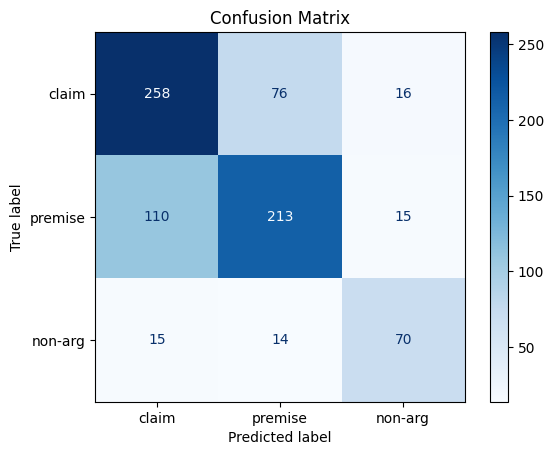

Final model saved to: ./final_model_bert-base-german-dbmdz-uncased_ArgUNSC_en_de
Misclassified examples saved to: misclassified_bert-base-german-dbmdz-uncased_ArgUNSC_en_de.xlsx
Misclassified examples saved to: misclassified_bert-base-german-dbmdz-uncased_ArgUNSC_en_de.xlsx


In [13]:
# Evaluation and Saving
print("\nEvaluating on test set...")

# Predict
predictions = final_trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
y_true = predictions.label_ids

# Report results
print(classification_report(y_true, y_pred, target_names=list(LABEL_MAP.keys())))
plot_confusion_matrix(y_true, y_pred, labels=list(LABEL_MAP.keys()))

# Clean up names for output
safe_model_name = MODEL_NAME.replace("/", "_")
safe_dataset_name = DATA_PATH.replace(".xlsx", "").replace(" ", "_")

# Save final model and tokenizer
model_path = f"./final_model_{safe_model_name}_{safe_dataset_name}"
final_trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
print(f"Final model saved to: {model_path}")

# Save misclassified examples for manual inspection
misclassified_filename = f"misclassified_{safe_model_name}_{safe_dataset_name}.xlsx"
save_misclassified(y_pred, y_true, test_df.reset_index(drop=True), tokenizer, misclassified_filename)
print(f"Misclassified examples saved to: {misclassified_filename}")


In [ ]:
import shutil
from google.colab import files

model_path = "./final_model_bert-base-german-dbmdz-uncased_ArgUNSC_en_de"

# Zip it
shutil.make_archive(model_path, 'zip', model_path)